# SIFT Feature Detection

El Scale-Invariant Feature Transform (SIFT) es un algoritmo, desarrollado por D. Lowe en 2004, para la extracción de `features` de una imagen. En un sentido abstracto, las `features` de una imagen son patrones o regiones fácilmente detectables y trackeables, a partir de las cuales podemos identificar y reconocer toda de objetos presentes en la imagen. Así, en términos simples, el algoritmo SIFT detecta puntos de interés `keypoints` dentro de una imágen y luego, si estos son lo suficientemente distinguibles, genera un desciptor para cada `keypoint` que permita identificarlo o, más importante, compararlo en el futuro.

https://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf

Análogamente a los workshops que hemos trabajado en las auxiliares pasadas, utilizaremos la implementación de SIFT en OpenCV para identificar cartas Pokemon en una foto, a partir de una serie de cartas de referencia. 



## OpenCV

La Open Surce Computer Vision es una librería especializada en herramientas de visión computacional y en todo lo que respecta a visión artificial en general. De este modo provee de funcionalidades de todo tipo de complejidad, desde operaciones básicas de procesamiento de imágenes, hasta algoritmos de reconocimiento de objetos.

Por supuesto, esta librería cuenta con su documentación correspondiente. En esta puede encontrar descripciones más detalladas de sus funcionalidades, así como también ejemplos, tutoriales y otros.

https://docs.opencv.org/master/

<img src="https://raw.githubusercontent.com/cherrerab/roboticafcfm/master/auxiliar_01/bin/opencv_logo.png" height="200">

Ahora, debido a conflictos de patentes la implementación de SIFT en OpenCV tuvo que ser movida a una librería complementaria `opencv-contrib`. De esta forma, para utilizarla en el workshop debemos instalar la librería en el entorno de Colab. 

In [ ]:
!pip install opencv-python==3.4.2.16 opencv-contrib-python==3.4.2.16

---
## Load Reference Images

La imagen que contiene la carta Pokemon que queremos identificar se encuentra en el archivo `img_01.jpg` dentro del github del curso. No obstante, antes de procesar ésta debemos extraer las `features` de una serie de cartas de referencia para así tener los `keypoints` y `descriptors` con los cuales podremos posteriormente comparar nuestra imagen de interés.

In [ ]:
!git clone https://github.com/cherrerab/roboticafcfm.git
%cd /content/roboticafcfm

A continuación cargaremos y exploraremos todas las imagenes contenidas en la carpeta `auxiliar_03/pokemon_cards`.

Podemos ver con cuantas cartas de referencia contamos mediante la función `os.listdir`, la cual retornará un listado de todos los archivos contenidos en la carpeta. 

In [ ]:
import os

# obtener lista con todos los archivos contenidos en pokemon_cards
# para esto podemos usar la función os.listdir
dir_path = 'auxiliar_03//pokemon_cards'
img_list = os.listdir(dir_path)

# print lista de cartas
print('cartas de referencia:\n', img_list)

cartas de referencia:
 ['tangela.jpg', 'meowth.jpg', 'aipom.jpg', 'jumpluff.jpg', 'charmander.jpg', 'vulpix.jpg']


Así, en `auxiliar_03/pokemon_cards` hay 6 archivos `.jpg`, donde cada uno de estas imágenes se corresponde con una carta pokemon. Ahora, recorreremos esta lista para cargar las imágenes utilizando `cv2.imread` y ajustarlas a un tamaño de `350x250px` mediante `cv2.resize`. De esta manera, generaremos una lista `ref_imgs` que contendrá los `np.array` con las imágenes de referencia.

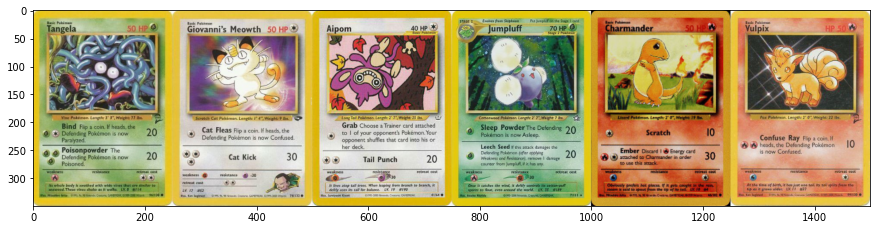

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import cv2

# inicializar lista que contendrá las imágenes np.array,
# también una que contendrá el nombre de los pokemones
ref_imgs, ref_names = [], []

# por cada imagen .jpg en img_list
for filename in img_list:
  # obtener nombre utilizando os.path.splitext
  img_name, _ = os.path.splitext(filename)

  # generar path del archivo con os.path.join
  img_path = os.path.join(dir_path, filename)

  # load imagen con cv2.imread
  img = cv2.imread(img_path)

  # resize a tamaño de 350x250px con cv2.resize
  img = cv2.resize(img, (250, 350))

  # agregar a listas
  ref_imgs.append(img)
  ref_names.append(img_name)

# ------------------------------------------------------------------------------
# concatenar cartas de referencia mediante np.hstack
cards = np.hstack( ref_imgs )

# visualizar
cards = cv2.cvtColor(cards, cv2.COLOR_BGR2RGB)

plt.figure( figsize=(15,15) )
plt.imshow(cards)


Excelente, hemos logrado generar la lista `ref_images` con todas nuestras cartas de referencia. Esta lista nos permitirá recorrer y procesar las imágenes de manera más cómoda y elegante.

## Extract Reference KeyPoints

Ahora procesaremos esta serie de cartas con SIFT para extraer sus `KeyPoints` y generar sus `Descriptors` correspondientes. La implementación de SIFT se encuentra en el módulo `cv2.xfeatures2d` el cual contiene distintos métodos de extracción de features y detección de `keypoints` como SIFT y SURF.

https://docs.opencv.org/3.4.2/d0/d13/classcv_1_1Feature2D.html

Para utilizar SIFT primero hay que inicializar el objeto mediante la función `cv2.xfeatures2d.SIFT_create` y luego utilizar la función `cv2.xfeatures2d_SIFT.detectAndCompute` sobre la imágen de interés para detectar los `Keypoints` y generar los `Descriptors`.



In [ ]:
# inicializar SIFT detector (cv2.xfeatures2d_SIFT)
sift = cv2.xfeatures2d.SIFT_create()

# incializar lista que contendrá los keypoints y descriptores
# de las cartas de referencia
ref_features = []

# para cada una de las cartas en ref_imgs
for img in ref_imgs:

  # transformar a escala de grises
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  # computar keypoint y descritores
  kps, des = sift.detectAndCompute(gray, mask=None)

  # agregar a lista
  ref_features.append( (kps, des) )

Una vez generadas las `features` de una imagen, estas pueden ser visualizadas mediante la función `cv2.drawKeypoints`. Si a esta función se le entrega como parámetro `flags` el objeto `cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS`, dibujará los `KeyPoints` utilizando la escala y orientación de estos.

Como ejemplo, a continuación dibujaremos los `KeyPoints` para la carta `Meowth`.

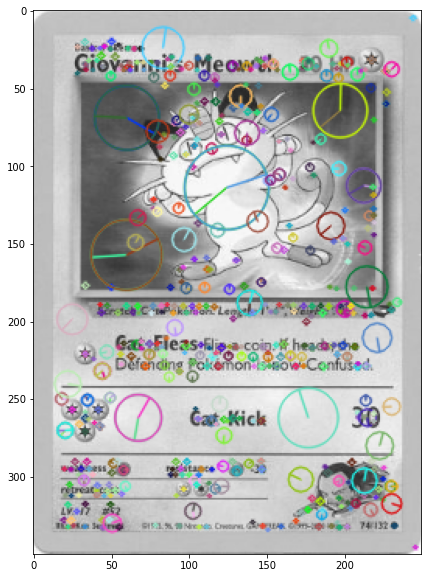

In [ ]:
# index en ref_imgs correspondiente a la carta meowth
idx = 1

# extraer imagen y convertir a escala de grises
gray = cv2.cvtColor(ref_imgs[idx], cv2.COLOR_BGR2GRAY)

# extraer keypoints y descriptores
kps, des = ref_features[idx]

# generar imagen donde se dibujarán los keypoints
out = np.zeros_like(gray)

# dibujar keypoints
out = cv2.drawKeypoints(gray, kps, out, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# visualizar
plt.figure( figsize=(10,10) )
plt.imshow(out)

---
## Feature Matching

Ya que tenemos las `features` de nuestras cartas de referencia en la lista `ref_features`, podemos pasar ahora a procesar nuestra imágen de interés `img_01.jpg`.

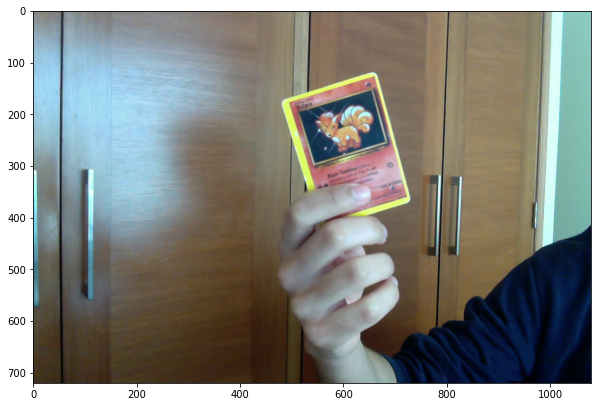

In [36]:
# cargar imagen img_01.jpg
img_path = 'auxiliar_03//img_01.jpg'
img = cv2.imread(img_path)

# convertir a RGB para visualizar
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# visualizar
plt.figure( figsize=(10,10) )
plt.imshow(rgb)

Del mismo modo en el que procesamos las imágenes de referencia, extraeremos los `KeyPoints` y `Descriptors` de esta imagen utilizando el mismo objeto `cv2.xfeatures2d_SIFT` anteriormente inicializado.

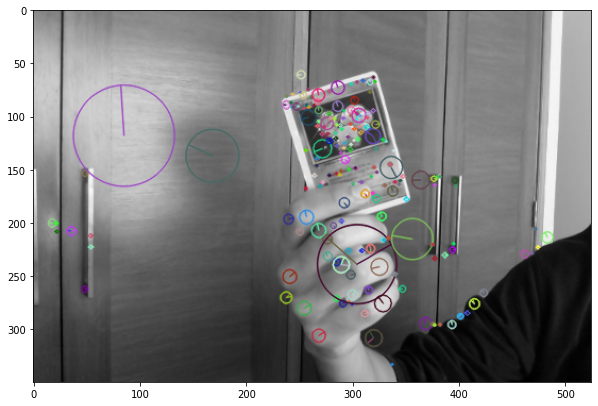

In [38]:
# para reducir el costo computacional reducir tamaño a (350x525)
img = cv2.resize(img, (525, 350))

# convertir imagen a escala de grises
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# computar keypoint y descritores
kps, des = sift.detectAndCompute(gray, mask=None)

# inicializar imagen para visualizar
out = np.zeros_like(gray)

# dibujar keypoints
out = cv2.drawKeypoints(gray, kps, out, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# visualizar
plt.figure( figsize=(10,10) )
plt.imshow(out)

Ahora que tenemos las `features` de nuestra imagen de interés debemos, debemos realizar un `matching` respecto a las `features` de las cartas de referencia para analizar la cantidad de coincidencias y así, qué carta posee la mayor cantidad de coincidencias.

Para esto, dado que los descriptores consisten en vectores de `(128, )` o bien, de 128 dimensiones, podemos utilizar como criterio la distancia euclidiana para evaluar que tan similares son dos `Descriptors` entre si o que tan cerca se encuentran en este espacio de 128 dimensiones. Así, realizaremos un `matching` de fuerza bruta mediante un `cv2.BFMatcher`, el cual a partir de un set de descriptores de `query` buscará los descriptores más cercanos en un set de `reference` para cada descriptor en el primer set.

https://docs.opencv.org/3.4/d3/da1/classcv_1_1BFMatcher.html

No obstante, cómo podemos validar si los `matches` realizados por `cv2.BFMatcher` son buenas coincidencias, pues siempre se podrá encontrar el descriptor más cercano a otro, incluso si estos no se encuentran a poca distancia.

Para resolver esto D. Lowe propone utilizar un `Ratio Test` para validar los `matches`. Primero, en vez de buscar el descriptor más cercano a otro, se buscan los 2 descriptores más cercanos. Luego, bajo el supuesto de que los descriptores generados por SIFT son lo suficientemente distintivos, no debiese ser posible que hayan dos coincidencias o `matches`. Así, si existe un `match` válido, la distancia de la primera coincidencia debería ser considerablemente menor a la de la segunda. Dicho de otra forma, si ambas distancias de `match` son similares, entonces la verdad es que no se hayó ninguna coincidencia significativa.

Para obtener los `k` descriptores más cercanos, podemos usar el método `cv2.BFMatcher.knnMatch`.

In [39]:
# inicializar BruteForce Matcher
# con criterio de distancia euclidiana, cv2.NORM_L2
BruteForce = cv2.BFMatcher(normType=cv2.NORM_L2)

# inicilizar lista que contendrá la cantida de coincidencias
ref_votes = np.zeros( (6, ) )

# para cada carta de referencia
for i, feature in enumerate( ref_features ):
  # extraer keypoints y descriptores
  kps_ref, des_ref = feature

  # para cada decriptor de img_01.jpg, encontrar los 2 mejores matches
  # con respecto a los descriptores de las cartas de referencia
  matches = BruteForce.knnMatch(des, des_ref, k=2)

  # por cada par de matches (match_1, match_2) obtenido
  # para cada descriptor en des_ref
  for match_1, match_2 in matches:

    # aplicar ratio test para filtrar matches
    ratio = 0.5
    if match_1.distance < ratio*match_2.distance:
      # agregar voto de match válido
      ref_votes[i] += 1

# ------------------------------------------------------------------------------
# print cantidad de votos
print('cantidad de votos:\n', ref_votes)

# obtener carta de coincidencia y probabilidad
ref_idx = np.argmax(ref_votes)
proba = ref_votes[ref_idx]/np.sum(ref_votes)

# print resultado
name = ref_names[ref_idx]
print('\n{:10s} {:2.1f}%'.format(name, proba*100))




cantidad de votos:
 [ 0.  0.  0.  0.  0. 19.]

vulpix     100.0%
